In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import potentials
from distances import *
from scipy.special import erfc
from matplotlib.widgets import Slider, Button, RadioButtons

In [2]:
boxsize = (0, 1)
L = boxsize[1] - boxsize[0]

In [3]:
class Ewald(object):
    def __init__(self, charges, boxsize,alpha, r_cutoff, n_max, k_cutoff, accuracy):
        #probably includes redundant parameters, will remove some in the future
        self.boxsize = boxsize
        self.L = boxsize[1] - boxsize[0]
        self.vol = self.L**3
        self.a = alpha
        self.rc = r_cutoff
        self.kc = k_cutoff
        self.e = accuracy
        self.q = charges
        self.k_array = np.asarray([[i,j, k] for i in range(int(k_cutoff)+1) 
                                   for j in range(int((k_cutoff**2-i**2)**(1/2))+1)
                                   for k in range(int((k_cutoff**2-i**2-j**2)**(1/2)+1)) if (i,j,k)!=(0,0,0)])
        self.k_array = np.concatenate([[i,j,k]*self.k_array for i in [-1, 1] for j in [-1, 1] for k in [-1, 1]])
        self.n_array = np.asarray([[i*L, j*L, k*L] 
                                   for i in range(-n_max, n_max+1) 
                                   for j in range(-n_max, n_max+1) 
                                   for k in range(-n_max, n_max+1)])
        
    def image_dvec(self, dvec, index_array):
        #return np.asarray([dvec + [self.L*i, self.L*j] for i in index_array for j in index_array])
        #creates particle-particle distance vectors for particle images in an order determined by index_array
        return np.asarray([dvec + [self.L*i, self.L*j, self.L*k] for i in index_array for j in index_array for k in index_array])
    
    def pot_sr(self, coord):
        #index_array = [0, -1, 1] #determines order of the image cells
        i_dvec = self.n_array[:,None,None]-vectors(coord, self.boxsize)
        #i_dvec = self.image_dvec(-vectors(coord, self.boxsize), index_array) #creates particle-particle vectors, including images
        dist = distances(i_dvec) #calculates the pairwise particle distances, including images
        mask = dist>=self.rc #particle-particle interactions are ignored if interparticle distance exceeds cutoff radius
        dist = np.ma.masked_array(dist, dist==0) #division by zero is prevented
        dist_ma = np.ma.masked_array(dist, mask) #applies cutoff mask to distance matrix
        return np.sum(self.q*np.ma.sum(1/2*self.q[None,:]*1/dist_ma*erfc(self.a*dist_ma), axis=(-1,0)))   
    
    def S(self,coord):
        #calculates the absolute squared of S(k) (structure factor inside imaginary part of Ewald sum)
        k_r = np.tensordot(self.k_array,coord, axes=(-1, -1)) #calculates the scalar product of all k-vectors with the position vectors k_r[i,j] = dot(k[i],r[j]) 
        s_re = np.tensordot(self.q, np.cos(2*np.pi*k_r), axes=(-1, -1))
        s_im = np.tensordot(self.q, np.sin(2*np.pi*k_r), axes=(-1, -1))
        return s_re**2 + s_im**2
        
    def pot_lr(self, coord):
        #long-ranged potential that is calculated in reciprocal space. Cutoff is defined by k_cutoff (see init)
        k_abs = np.linalg.norm(self.k_array,axis=-1)
        return 1/(2*np.pi*self.vol)*np.sum((np.exp(-(np.pi*k_abs/self.a)**2)/k_abs**2)*self.S(coord))
    
    def pot_self(self):
        #self-interaction potential, that has to be corrected for in the Ewald sum
        return self.a/np.sqrt(np.pi)*np.linalg.norm(self.q)**2
    
    def pot(self, coord):
        return np.ma.sum((self.pot_sr(coord),self.pot_lr(coord), - self.pot_self()))
        
        

In [4]:
def nacl_ewald(r_cutoff, n_max, k_cutoff):
    charges = np.asarray([-1, -1., -1, -1, 1, 1, 1, 1])
    coord =np.asarray([[0,0,0], [1/2,1/2,0], [1/2,0,1/2], [0,1/2,1/2],
                       [1/2,1/2,1/2], [1/2,0,0], [0,1/2,0],[0,0,1/2]])
    a_array = np.arange(0.1, 5, 0.1)
    E_array = [Ewald(charges,(0,1),a_i,r_cutoff, n_max, k_cutoff, 1e-10) for a_i in a_array]
    pot_lr = np.asarray([E.pot_lr(coord) for E in E_array])
    pot_sr = np.asarray([E.pot_sr(coord) for E in E_array])
    pot_self = [E.pot_self() for E in E_array]
    pot_total = pot_lr + pot_sr - pot_self
    return a_array, pot_lr, pot_sr, pot_self, pot_total

In [5]:
a_array, pot_lr, pot_sr, pot_self, pot_total =nacl_ewald(10, 10, 10)

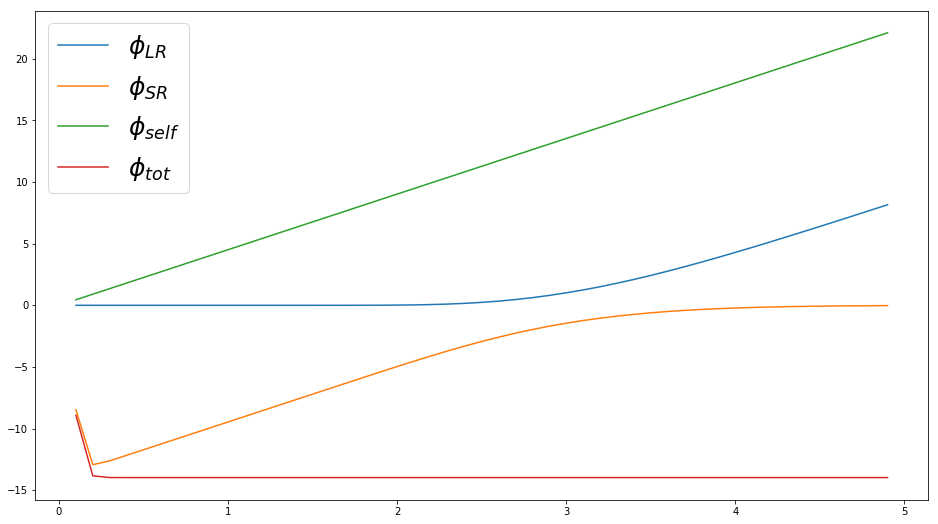

Madelung's constant from Ewald: -1.7475645946331824
Madelung's constant from liter: -1.7475645946331821


In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(a_array, pot_lr, label="$\phi_{LR}$")
ax.plot(a_array, pot_sr, label="$\phi_{SR}$")
ax.plot(a_array, pot_self, label="$\phi_{self}$")
ax.plot(a_array, pot_total, label="$\phi_{tot}$")
ax.legend(fontsize=25)
plt.show()
print("Madelung's constant from Ewald:",np.sum(pot_total[12:]/len(pot_total[12:])/8))
print("Madelung's constant from liter:",-1.7475645946331821)